In [4]:
!pip install opencv-python numpy matplotlib ipywidgets
!jupyter nbextension enable --py widgetsnbextension


Defaulting to user installation because normal site-packages is not writeable
usage: jupyter [-h] [--version] [--config-dir] [--data-dir] [--runtime-dir]
               [--paths] [--json] [--debug]
               [subcommand]

Jupyter: Interactive Computing

positional arguments:
  subcommand     the subcommand to launch

optional arguments:
  -h, --help     show this help message and exit
  --version      show the versions of core jupyter packages and exit
  --config-dir   show Jupyter config dir
  --data-dir     show Jupyter data dir
  --runtime-dir  show Jupyter runtime dir
  --paths        show all Jupyter paths. Add --json for machine-readable
                 format.
  --json         output paths as machine-readable json
  --debug        output debug information about paths

Available subcommands: execute kernel kernelspec migrate run troubleshoot

Jupyter command `jupyter-nbextension` not found.


In [20]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider, fixed  # <-- added 'fixed'
%matplotlib inline



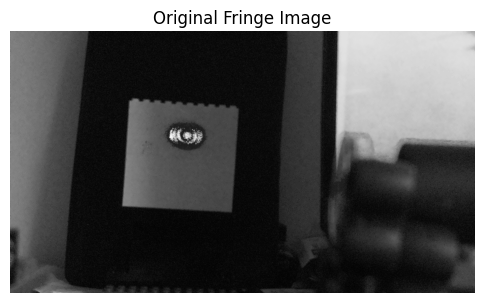

In [21]:
# User-defined image path
image_path = "/home/kyra/programming/michelson/captured_images/image_000.jpg"  # <-- Adjust your file path here

# Load the image
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Display original image
plt.figure(figsize=(6,6))
plt.title("Original Fringe Image")
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.show()


In [22]:
# Auto-detect fringe center using HoughCircles (once)
blurred = cv2.GaussianBlur(image, (9,9), 2)
circles = cv2.HoughCircles(blurred, cv2.HOUGH_GRADIENT, 1, 20,
                           param1=100, param2=30, minRadius=10, maxRadius=200)

if circles is not None:
    circles = np.uint16(np.around(circles))
    center_x, center_y = circles[0][0][0], circles[0][0][1]
    print(f"Auto-detected center: ({center_x}, {center_y})")
else:
    center_x, center_y = image.shape[1]//2, image.shape[0]//2
    print("Auto-detection failed. Using image center instead.")

# You can manually override center if desired:
# center_x, center_y = 320, 240  # Example manual override


Auto-detected center: (732, 426)


In [23]:
def detect_fixed_center_circles(center_x, center_y, param1, param2, minRadius, maxRadius):
    img_copy = image.copy()
    blurred = cv2.GaussianBlur(img_copy, (9,9), 2)

    # Detect circles around fixed center using HoughCircles
    circles = cv2.HoughCircles(blurred, 
                               cv2.HOUGH_GRADIENT, dp=1, minDist=10,
                               param1=param1, param2=param2,
                               minRadius=minRadius, maxRadius=maxRadius)
    
    display_img = cv2.cvtColor(img_copy, cv2.COLOR_GRAY2BGR)
    cv2.circle(display_img, (center_x, center_y), 3, (255,0,0), -1)  # Center point
    
    detected_radii = []

    if circles is not None:
        circles = np.uint16(np.around(circles))[0]
        
        # Sort circles by radius
        circles = sorted(circles, key=lambda c: c[2])

        for c in circles:
            radius = int(np.sqrt((c[0]-center_x)**2 + (c[1]-center_y)**2)) + c[2]
            detected_radii.append(radius)
            cv2.circle(display_img, (center_x, center_y), radius, (0,255,0), 2)
            cv2.putText(display_img, f"r={radius}px", 
                        (center_x + radius - 40, center_y), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,0,0), 1)

        # Display detected fringes
        plt.figure(figsize=(8,8))
        plt.title("Detected Fringes with Fixed Center")
        plt.imshow(display_img)
        plt.axis('off')
        plt.show()

        print("Measured Radii (from fixed center):")
        for idx, r in enumerate(detected_radii, 1):
            print(f"Fringe {idx}: Radius = {r} pixels")

    else:
        print("No fringes detected. Adjust parameters.")

interact(detect_fixed_center_circles, 
         center_x=fixed(center_x), 
         center_y=fixed(center_y),
         param1=IntSlider(min=50, max=300, step=10, value=100, description='Canny Param1'),
         param2=IntSlider(min=10, max=100, step=2, value=30, description='Circle Param2'),
         minRadius=IntSlider(min=5, max=100, step=2, value=10, description='Min Radius'),
         maxRadius=IntSlider(min=20, max=500, step=10, value=200, description='Max Radius'));


interactive(children=(IntSlider(value=100, description='Canny Param1', max=300, min=50, step=10), IntSlider(va…

In [19]:
def measure_fringe_spacing(radii_px, scale_mm_per_px=1):
    sorted_radii = sorted(radii_px)
    fringe_widths_px = np.diff(sorted_radii)
    fringe_widths_mm = fringe_widths_px * scale_mm_per_px

    print("Fringe width measurements:")
    for idx, width in enumerate(fringe_widths_mm, 1):
        print(f"Width between fringe {idx} and {idx+1}: {width:.2f} mm")

# Example usage (replace with your detected radii):
example_detected_radii = [100, 125, 148, 170]  # <-- update these based on actual detection
scale_mm_per_px = 0.05  # Calibration scale in mm/px

measure_fringe_spacing(example_detected_radii, scale_mm_per_px)


Fringe width measurements:
Width between fringe 1 and 2: 1.25 mm
Width between fringe 2 and 3: 1.15 mm
Width between fringe 3 and 4: 1.10 mm


In [12]:
# Saving the last displayed figure (adjust filename)
annotated_filename = 'fringe_analysis_result.png'
plt.savefig(annotated_filename, dpi=300)
print(f"Annotated image saved as '{annotated_filename}'")


Annotated image saved as 'fringe_analysis_result.png'


<Figure size 640x480 with 0 Axes>